<a href="https://colab.research.google.com/github/gabrielpetersson/simple-variational-auto-encoder/blob/master/cifar_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Transformations for training and testing data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomHorizontalFlip(),     # Random horizontal flip
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),  # Normalize with mean and std
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),  # Normalize with mean and std
                         (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:12<00:00, 13405386.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)  # Output: (batch_size, 3, 32, 32)
print(labels.shape)  # Output: (batch_size)

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import math

def sample_images(model, noise_schedule, num_samples=10, device='cuda'):
    model.eval()
    model.to(device)

    # Precompute constants
    betas = noise_schedule.to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)
    timesteps = noise_schedule.shape[0]

    # Start from random noise
    x_t = torch.randn(num_samples, 3, 32, 32).to(device)

    for t in reversed(range(0, timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.float32)

        # Normalize the time tensor by the total timesteps
        t_tensor = t_tensor / timesteps

        # Predict noise using the model
        with torch.no_grad():
            noise_pred = model(x_t, t_tensor.view(-1, 1, 1, 1))

        beta_t = betas[t]
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
        sqrt_recip_alpha_t = 1 / torch.sqrt(1 - beta_t)

        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)

        # Update x_t to x_{t-1} using the reverse diffusion equation
        x_t = (1 / torch.sqrt(1 - beta_t)) * (x_t - (beta_t / sqrt_one_minus_alpha_cumprod_t) * noise_pred) + torch.sqrt(beta_t) * noise

    # x_t now contains the generated images x_0
    x_0 = x_t
    x_0 = x_0.detach().cpu()

    # Unnormalize the images (assuming normalization was with mean=0.5, std=0.5)
    x_0 = x_0 * 0.5 + 0.5
    x_0 = torch.clamp(x_0, 0.0, 1.0)

    # Create a grid of images and display them
    grid = torchvision.utils.make_grid(x_0, nrow=5)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

def sample_images2(model, noise_schedule, num_samples=10, device='cuda'):
    model.eval()
    model.to(device)

    # Precompute constants
    betas = noise_schedule.to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)
    timesteps = noise_schedule.shape[0]

    # Start from random noise
    x_t = torch.randn(num_samples, 3, 32, 32).to(device)

    for t in reversed(range(0, timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.float32)

        # Predict noise using the model
        with torch.no_grad():
            noise_pred = model(x_t, t_tensor.view(-1, 1, 1, 1))

        beta_t = betas[t]
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
        sqrt_recip_alpha_t = 1 / torch.sqrt(1 - beta_t)

        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)

        # Update x_t to x_{t-1} using the reverse diffusion equation
        x_t = (1 / torch.sqrt(1 - beta_t)) * (x_t - (beta_t / sqrt_one_minus_alpha_cumprod_t) * noise_pred) + torch.sqrt(beta_t) * noise

    # x_t now contains the generated images x_0
    x_0 = x_t
    x_0 = x_0.detach().cpu()

    # Unnormalize the images (assuming normalization was with mean=0.5, std=0.5)
    x_0 = x_0 * 0.5 + 0.5
    x_0 = torch.clamp(x_0, 0.0, 1.0)

    # Create a grid of images and display them
    grid = torchvision.utils.make_grid(x_0, nrow=5)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DiffusionModel(nn.Module):
    def __init__(self, img_size=32, channels=3, timesteps=1000):
        super(DiffusionModel, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.timesteps = timesteps

        # Update the first Conv2d to accept channels + 1 input channels
        self.encoder = nn.Sequential(
            nn.Conv2d(channels + 1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, channels, kernel_size=3, padding=1),
        )

    def forward(self, x, t):
        # Ensure t is a tensor of shape (batch_size,)
        if not isinstance(t, torch.Tensor):
            t = torch.tensor([t] * x.size(0), device=x.device)

        # Embed the timestep information as an additional channel
        t = t.view(-1, 1, 1, 1)  # Shape: (batch_size, 1, 1, 1)
        t_embedded = t.expand(-1, 1, x.size(2), x.size(3))  # Shape: (batch_size, 1, H, W)
        x = torch.cat([x, t_embedded], dim=1)  # Now x has channels + 1 channels

        # Encode the input
        encoded = self.encoder(x)

        # Apply middle layers (bottleneck)
        middle = self.middle(encoded)

        # Decode the features
        decoded = self.decoder(middle)
        return decoded

class DiffusionModel2(nn.Module):
    def __init__(self, img_size=32, channels=3, timesteps=1000):
        super(DiffusionModel2, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.timesteps = timesteps

        # Positional embedding for timestep
        self.time_embed = nn.Sequential(
            nn.Linear(1, 256),  # Output dimension matches channels in h
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
        )

        # Encoder layers with increased capacity
        self.encoder = nn.ModuleList([
            nn.Conv2d(channels, 64, kernel_size=3, padding=1),
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.GroupNorm(8, 256),
            nn.SiLU(),
        ])

        # Middle layers
        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(8, 256),
            nn.SiLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(8, 256),
            nn.SiLU(),
        )

        # Decoder layers with skip connections
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv2d(67, channels, kernel_size=3, padding=1)
            #nn.Conv2d(128, channels, kernel_size=3, padding=1),
        ])

    def forward(self, x, t):
        batch_size = x.size(0)

        # Time embedding
        t = t.view(batch_size, 1).float() / self.timesteps  # Normalize t
        t_emb = self.time_embed(t)  # Shape: (batch_size, 256)
        t_emb = t_emb.view(batch_size, 256, 1, 1)  # Shape: (batch_size, 256, 1, 1)

        # Initial convolution
        h = x
        skips = []

        # Encoder with skip connections
        for i in range(0, len(self.encoder), 3):
            h = self.encoder[i](h)
            h = self.encoder[i+1](h)
            h = self.encoder[i+2](h)
            skips.append(h)

        # Middle layers
        h = self.middle(h + t_emb)

        # Decoder with skip connections
        for i in range(0, len(self.decoder) - 1, 3):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = self.decoder[i](h)
            h = self.decoder[i+1](h)
            h = self.decoder[i+2](h)

        # Output layer
        h = torch.cat([h, x], dim=1)  # Skip connection from input
        out = self.decoder[-1](h)
        return out

class DiffusionModel3(nn.Module):
    def __init__(self, img_size=32, channels=3, timesteps=1000):
        super(DiffusionModel3, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.timesteps = timesteps

        # Positional embedding for timestep
        self.time_embed = nn.Sequential(
            nn.Linear(1, 512),  # Increased from 256 to 512
            nn.SiLU(),
            nn.Linear(512, 512),
            nn.SiLU(),
        )

        # Encoder layers with increased capacity
        self.encoder = nn.ModuleList([
            nn.Conv2d(channels, 128, kernel_size=3, padding=1),  # Increased from 64 to 128
            nn.GroupNorm(16, 128),
            nn.SiLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Increased from 128 to 256
            nn.GroupNorm(16, 256),
            nn.SiLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # Increased from 256 to 512
            nn.GroupNorm(16, 512),
            nn.SiLU(),
        ])

        # Middle layers with increased capacity
        self.middle = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(16, 512),
            nn.SiLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(16, 512),
            nn.SiLU(),
        )

        # Decoder layers with increased capacity
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),  # Input channels increased due to concatenation
            nn.GroupNorm(16, 256),
            nn.SiLU(),
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(16, 128),
            nn.SiLU(),
            nn.Conv2d(131, channels, kernel_size=3, padding=1),  # Input channels adjusted due to concatenation
        ])

    def forward(self, x, t):
        batch_size = x.size(0)

        # Time embedding
        t = t.view(batch_size, 1).float() / self.timesteps  # Normalize t
        t_emb = self.time_embed(t)  # Shape: (batch_size, 512)
        t_emb = t_emb.view(batch_size, 512, 1, 1)  # Shape: (batch_size, 512, 1, 1)

        # Initial convolution
        h = x
        skips = []

        # Encoder with skip connections
        for i in range(0, len(self.encoder), 3):
            h = self.encoder[i](h)
            h = self.encoder[i + 1](h)
            h = self.encoder[i + 2](h)
            skips.append(h)

        # Middle layers
        h = self.middle(h + t_emb)

        # Decoder with skip connections
        for i in range(0, len(self.decoder) - 1, 3):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = self.decoder[i](h)
            h = self.decoder[i + 1](h)
            h = self.decoder[i + 2](h)

        # Output layer
        h = torch.cat([h, x], dim=1)  # Concatenate with input x
        out = self.decoder[-1](h)
        return out


class DiffusionModel4(nn.Module):
    def __init__(self, img_size=32, channels=3, timesteps=1000):
        super(DiffusionModel4, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.timesteps = timesteps

        # Positional embedding for timestep
        self.time_embed = nn.Sequential(
            nn.Linear(1, 1024),  # Increased from 512 to 1024
            nn.SiLU(),
            nn.Linear(1024, 1024),
            nn.SiLU(),
        )

        # Encoder layers with increased capacity and dropout
        self.encoder = nn.ModuleList([
            nn.Conv2d(channels, 256, kernel_size=3, padding=1),  # Increased from 128 to 256
            nn.GroupNorm(32, 256),
            nn.SiLU(),
            nn.Dropout(p=0.1),  # Added dropout with p=0.1
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(32, 1024),
            nn.SiLU(),
            nn.Dropout(p=0.1),
        ])

        # Middle layers with dropout
        self.middle = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.GroupNorm(32, 1024),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.GroupNorm(32, 1024),
            nn.SiLU(),
            nn.Dropout(p=0.1),
        )

        # Decoder layers with increased capacity and dropout
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1), #
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(32, 256),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(259, channels, kernel_size=3, padding=1),
            # Output layer (no dropout here)
        ])

    def forward(self, x, t):
        batch_size = x.size(0)

        # Time embedding
        t = t.view(batch_size, 1).float() / self.timesteps  # Normalize t
        t_emb = self.time_embed(t)  # Shape: (batch_size, 1024)
        t_emb = t_emb.view(batch_size, 1024, 1, 1)  # Shape: (batch_size, 1024, 1, 1)

        # Initial input
        h = x
        skips = []

        # Encoder with skip connections and dropout
        for i in range(0, len(self.encoder), 4):
            h = self.encoder[i](h)         # Conv2d
            h = self.encoder[i+1](h)       # GroupNorm
            h = self.encoder[i+2](h)       # SiLU activation
            h = self.encoder[i+3](h)       # Dropout
            skips.append(h)

        # Middle layers with dropout
        h = h + t_emb
        h = self.middle(h)

        # Decoder with skip connections and dropout
        for i in range(0, len(self.decoder) - 1, 4):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = self.decoder[i](h)         # ConvTranspose2d
            h = self.decoder[i+1](h)       # GroupNorm
            h = self.decoder[i+2](h)       # SiLU activation
            h = self.decoder[i+3](h)       # Dropout

        # Output layer
        h = torch.cat([h, x], dim=1)       # Concatenate with input x
        out = self.decoder[-1](h)          # Final Conv2d layer
        return out


class DiffusionModel5(nn.Module):
    def __init__(self, img_size=32, channels=3, timesteps=1000):
        super(DiffusionModel5, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.timesteps = timesteps

        # Positional embedding for timestep
        self.time_embed = nn.Sequential(
            nn.Linear(1, 2048),  # Increased from 1024 to 2048
            nn.SiLU(),
            nn.Linear(2048, 2048),
            nn.SiLU(),
        )

        # Encoder layers with increased capacity and dropout
        self.encoder = nn.ModuleList([
            nn.Conv2d(channels, 512, kernel_size=3, padding=1),  # Increased from 256 to 512
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Dropout(p=0.1),  # Dropout with p=0.1
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),  # Increased from 512 to 1024
            nn.GroupNorm(32, 1024),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),  # Increased from 1024 to 2048
            nn.GroupNorm(32, 2048),
            nn.SiLU(),
            nn.Dropout(p=0.1),
        ])

        # Middle layers with increased capacity and dropout
        self.middle = nn.Sequential(
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.GroupNorm(32, 2048),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.GroupNorm(32, 2048),
            nn.SiLU(),
            nn.Dropout(p=0.1),
        )

        # Decoder layers with increased capacity and dropout
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(4096, 1024, kernel_size=4, stride=2, padding=1),  # Input channels increased due to concatenation
            nn.GroupNorm(32, 1024),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(32, 512),
            nn.SiLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(515, channels, kernel_size=3, padding=1),  # Input channels adjusted due to concatenation
            # Output layer (no dropout here)
        ])

    def forward(self, x, t):
        batch_size = x.size(0)

        # Time embedding
        t = t.view(batch_size, 1).float() / self.timesteps  # Normalize t
        t_emb = self.time_embed(t)  # Shape: (batch_size, 2048)
        t_emb = t_emb.view(batch_size, 2048, 1, 1)  # Shape: (batch_size, 2048, 1, 1)

        # Initial input
        h = x
        skips = []

        # Encoder with skip connections and dropout
        for i in range(0, len(self.encoder), 4):
            h = self.encoder[i](h)         # Conv2d
            h = self.encoder[i+1](h)       # GroupNorm
            h = self.encoder[i+2](h)       # SiLU activation
            h = self.encoder[i+3](h)       # Dropout
            skips.append(h)

        # Middle layers with dropout
        h = h + t_emb
        h = self.middle(h)

        # Decoder with skip connections and dropout
        for i in range(0, len(self.decoder) - 1, 4):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = self.decoder[i](h)         # ConvTranspose2d
            h = self.decoder[i+1](h)       # GroupNorm
            h = self.decoder[i+2](h)       # SiLU activation
            h = self.decoder[i+3](h)       # Dropout

        # Output layer
        h = torch.cat([h, x], dim=1)       # Concatenate with input x
        out = self.decoder[-1](h)          # Final Conv2d layer
        return out

class DiffusionModel6(nn.Module):
    def __init__(self, img_size=32, channels=3, timesteps=1000):
        super(DiffusionModel6, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.timesteps = timesteps

        # Positional embedding for timestep with increased capacity
        self.time_embed = nn.Sequential(
            nn.Linear(1, 3072),  # Increased from 2048 to 3072
            nn.SiLU(),
            nn.Linear(3072, 3072),
            nn.SiLU(),
        )

        # Encoder layers with increased capacity
        self.encoder = nn.ModuleList([
            nn.Conv2d(channels, 768, kernel_size=3, padding=1),  # Increased from 512 to 768
            nn.GroupNorm(32, 768),
            nn.SiLU(),
            nn.Dropout(p=0.001),  # Keep dropout rate the same
            nn.Conv2d(768, 1536, kernel_size=3, stride=2, padding=1),  # Increased from 1024 to 1536
            nn.GroupNorm(32, 1536),
            nn.SiLU(),
            nn.Dropout(p=0.001),
            nn.Conv2d(1536, 3072, kernel_size=3, stride=2, padding=1),  # Increased from 2048 to 3072
            nn.GroupNorm(32, 3072),
            nn.SiLU(),
            nn.Dropout(p=0.001),
        ])

        # Middle layers with increased capacity and additional layers
        self.middle = nn.Sequential(
            nn.Conv2d(3072, 3072, kernel_size=3, padding=1),
            nn.GroupNorm(32, 3072),
            nn.SiLU(),
            nn.Dropout(p=0.001),
            nn.Conv2d(3072, 3072, kernel_size=3, padding=1),
            nn.GroupNorm(32, 3072),
            nn.SiLU(),
            nn.Dropout(p=0.001),
        )

        # Decoder layers with increased capacity
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(6144, 1536, kernel_size=4, stride=2, padding=1),  # Adjusted for concatenation
            nn.GroupNorm(32, 1536),
            nn.SiLU(),
            nn.Dropout(p=0.001),
            nn.ConvTranspose2d(3072, 768, kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(32, 768),
            nn.SiLU(),
            nn.Dropout(p=0.001),
            nn.Conv2d(771, channels, kernel_size=3, padding=1),  # Adjusted for concatenation with input x
            # Output layer (no dropout here)
        ])

    def forward(self, x, t):
        batch_size = x.size(0)

        # Time embedding
        t = t.view(batch_size, 1).float() / self.timesteps  # Normalize t
        t_emb = self.time_embed(t)  # Shape: (batch_size, 3072)
        t_emb = t_emb.view(batch_size, 3072, 1, 1)  # Shape: (batch_size, 3072, 1, 1)

        # Initial input
        h = x
        skips = []

        # Encoder with skip connections
        for i in range(0, len(self.encoder), 4):
            h = self.encoder[i](h)         # Conv2d
            h = self.encoder[i+1](h)       # GroupNorm
            h = self.encoder[i+2](h)       # SiLU activation
            h = self.encoder[i+3](h)       # Dropout
            skips.append(h)

        # Middle layers
        h = h + t_emb
        h = self.middle(h)

        # Decoder with skip connections
        for i in range(0, len(self.decoder) - 1, 4):
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)  # Concatenate skip connection
            h = self.decoder[i](h)           # ConvTranspose2d
            h = self.decoder[i+1](h)         # GroupNorm
            h = self.decoder[i+2](h)         # SiLU activation
            h = self.decoder[i+3](h)         # Dropout

        # Output layer
        h = torch.cat([h, x], dim=1)         # Concatenate with input x
        out = self.decoder[-1](h)            # Final Conv2d layer
        return out

# Helper function to create noise schedule
#def linear_beta_schedule(timesteps):
#    beta_start = 0.0001
#    beta_end = 0.02
#    return torch.linspace(beta_start, beta_end, timesteps)

def linear_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule for beta values.
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * (math.pi / 2)) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.02)  # Clipping to avoid extremely small or large values
    return betas

def forward_diffusion(x_0, t, noise_schedule):
    # Ensure t is a tensor of shape (batch_size,) and of type LongTensor
    if not isinstance(t, torch.Tensor):
        t = torch.tensor([t] * x_0.size(0), device=x_0.device, dtype=torch.long)
    else:
        t = t.to(x_0.device).long()

    noise = torch.randn_like(x_0)

    # Move noise_schedule to the same device as x_0
    noise_schedule = noise_schedule.to(x_0.device)

    # Precompute alphas_cumprod
    alphas = 1 - noise_schedule
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Get alpha_t for each batch element
    alpha_t = alphas_cumprod[t]  # Shape: (batch_size,)
    alpha_t = alpha_t.view(-1, 1, 1, 1)  # Reshape for broadcasting

    x_t = torch.sqrt(alpha_t) * x_0 + torch.sqrt(1 - alpha_t) * noise
    return x_t, noise

In [ ]:
import math
import time
import torch.optim as optim
import torch.cuda.amp as amp  # For mixed precision training

# Hyperparameters
timesteps = 1000
noise_schedule = linear_beta_schedule(timesteps).to('cuda')  # Moved to CUDA once
learning_rate = 0.00002

# Create model, loss function, and optimizer
model = DiffusionModel6().to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Optional: LR scheduler for better convergence
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Adjust gamma as needed

# Gradient scaler for mixed precision training
scaler = amp.GradScaler()

def train(model, trainloader, testloader, epochs=20):
    total_epochs = epochs
    total_batches = len(trainloader)
    print(f'Starting training for {total_epochs} epochs with {total_batches} batches per epoch.')



    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0.0
        total_data = 0
        data_since_last_print = 0
        loss_since_last_print = 0.0

        for i, data in enumerate(trainloader, 1):
            inputs, _ = data
            inputs = inputs.to('cuda')

            optimizer.zero_grad()

            # Sample random timesteps
            t = torch.randint(0, timesteps, (inputs.size(0),), device=inputs.device)

            # Forward diffusion
            noisy_imgs, noise = forward_diffusion(inputs, t, noise_schedule)

            # Mixed precision training (faster and uses less memory)
            with amp.autocast():
                # Predict noise
                noise_pred = model(noisy_imgs, t.float().unsqueeze(1).unsqueeze(1).unsqueeze(1))

                # Compute loss
                loss = criterion(noise_pred, noise)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Optional: Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step with gradient scaling
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item() * inputs.size(0)
            total_loss += batch_loss
            total_data += inputs.size(0)
            data_since_last_print += inputs.size(0)
            loss_since_last_print += batch_loss

            # Print loss every 10,000 data points
            if data_since_last_print >= 10000:
                avg_loss = loss_since_last_print / data_since_last_print
                print(f'Epoch [{epoch + 1}/{total_epochs}], Data [{total_data}/{len(trainloader.dataset)}], '
                      f'Average Loss: {avg_loss:.4f}')
                data_since_last_print = 0
                loss_since_last_print = 0.0

        # Learning rate scheduling (if using scheduler)
        scheduler.step()

        epoch_duration = time.time() - epoch_start_time
        avg_epoch_loss = total_loss / total_data
        print(f'Epoch [{epoch + 1}/{total_epochs}] completed in {epoch_duration:.2f}s')
        print(f'Epoch [{epoch + 1}/{total_epochs}] Average Training Loss: {avg_epoch_loss:.4f}')
        sample_images(model, noise_schedule, num_samples=10, device='cuda')
        sample_images2(model, noise_schedule, num_samples=10, device='cuda')

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in testloader:
                inputs, _ = data
                inputs = inputs.to('cuda')

                # Sample random timesteps
                t = torch.randint(0, timesteps, (inputs.size(0),), device=inputs.device)

                # Forward diffusion
                noisy_imgs, noise = forward_diffusion(inputs, t, noise_schedule)

                # Predict noise
                noise_pred = model(noisy_imgs, t.float().unsqueeze(1).unsqueeze(1).unsqueeze(1))

                # Compute loss
                loss = criterion(noise_pred, noise)
                val_loss += loss.item() * inputs.size(0)

            val_loss /= len(testloader.dataset)
            print(f'Epoch [{epoch + 1}/{total_epochs}] Validation Loss: {val_loss:.4f}')
            print('-' * 50)

    print('Training finished.')

<ipython-input-14-ec7e856aaf2f>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Initial Validation Loss before training: 1.1071
--------------------------------------------------


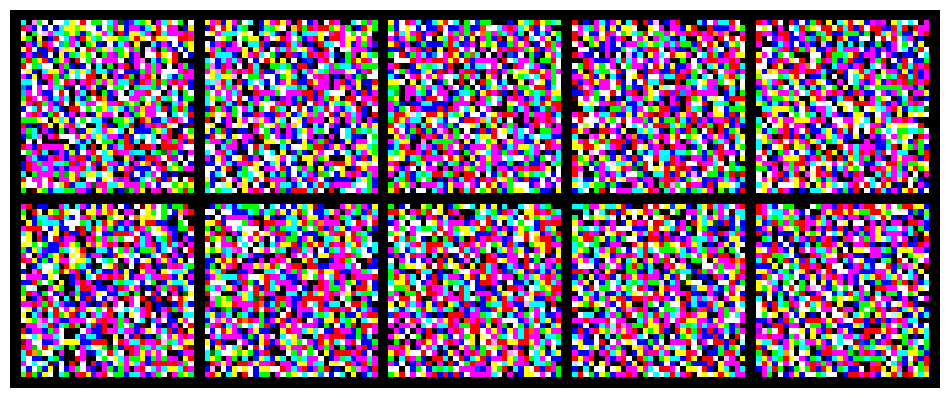

In [ ]:
    # Initial validation before training
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            inputs = inputs.to('cuda')

            # Sample random timesteps
            t = torch.randint(0, timesteps, (inputs.size(0),), device=inputs.device)

            # Forward diffusion
            noisy_imgs, noise = forward_diffusion(inputs, t, noise_schedule)

            # Predict noise
            noise_pred = model(noisy_imgs, t.float().unsqueeze(1).unsqueeze(1).unsqueeze(1))

            # Compute loss
            loss = criterion(noise_pred, noise)
            val_loss += loss.item() * inputs.size(0)

        val_loss /= len(testloader.dataset)
        print(f'Initial Validation Loss before training: {val_loss:.4f}')
        print('-' * 50)

    # Optionally sample images at the start
    sample_images(model, noise_schedule, num_samples=10, device='cuda')

Starting training for 20 epochs with 391 batches per epoch.


<ipython-input-14-ec7e856aaf2f>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [1/20], Data [10112/50000], Average Loss: 0.4196
Epoch [1/20], Data [20224/50000], Average Loss: 0.1795
Epoch [1/20], Data [30336/50000], Average Loss: 0.1504
Epoch [1/20], Data [40448/50000], Average Loss: 0.1379
Epoch [1/20] completed in 861.02s
Epoch [1/20] Average Training Loss: 0.2043


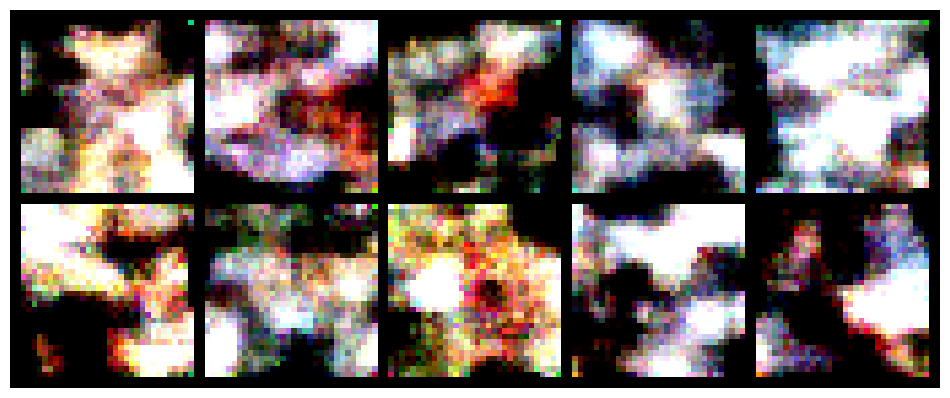

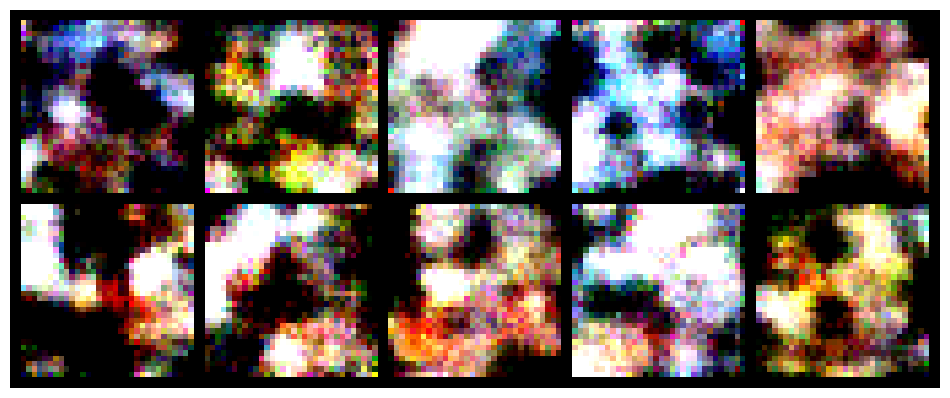

Epoch [1/20] Validation Loss: 0.1191
--------------------------------------------------
Epoch [2/20], Data [10112/50000], Average Loss: 0.1206
Epoch [2/20], Data [20224/50000], Average Loss: 0.1155
Epoch [2/20], Data [30336/50000], Average Loss: 0.1157
Epoch [2/20], Data [40448/50000], Average Loss: 0.1099
Epoch [2/20] completed in 859.90s
Epoch [2/20] Average Training Loss: 0.1144


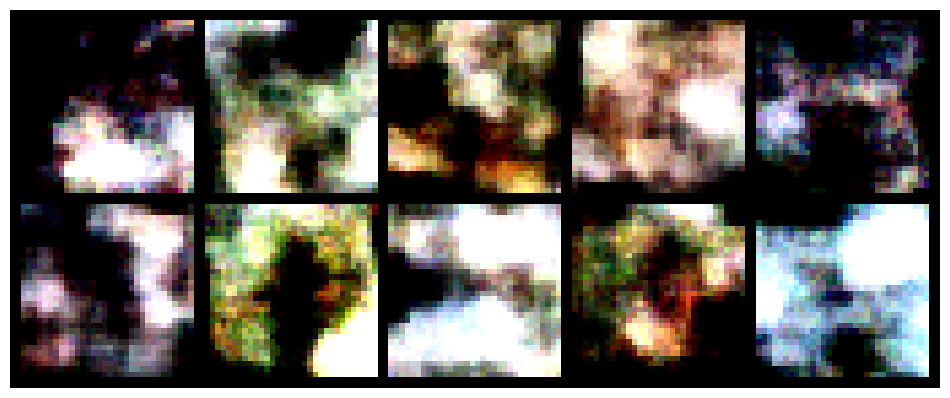

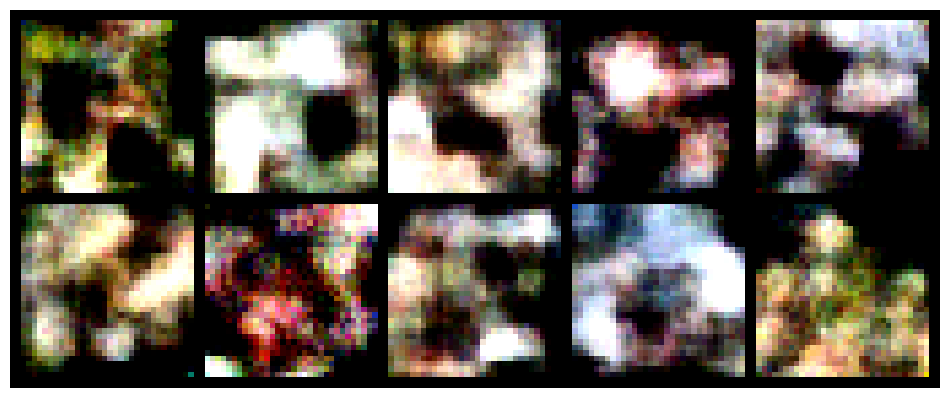

Epoch [2/20] Validation Loss: 0.1043
--------------------------------------------------
Epoch [3/20], Data [10112/50000], Average Loss: 0.1085
Epoch [3/20], Data [20224/50000], Average Loss: 0.1067
Epoch [3/20], Data [30336/50000], Average Loss: 0.1050
Epoch [3/20], Data [40448/50000], Average Loss: 0.1036
Epoch [3/20] completed in 859.09s
Epoch [3/20] Average Training Loss: 0.1047


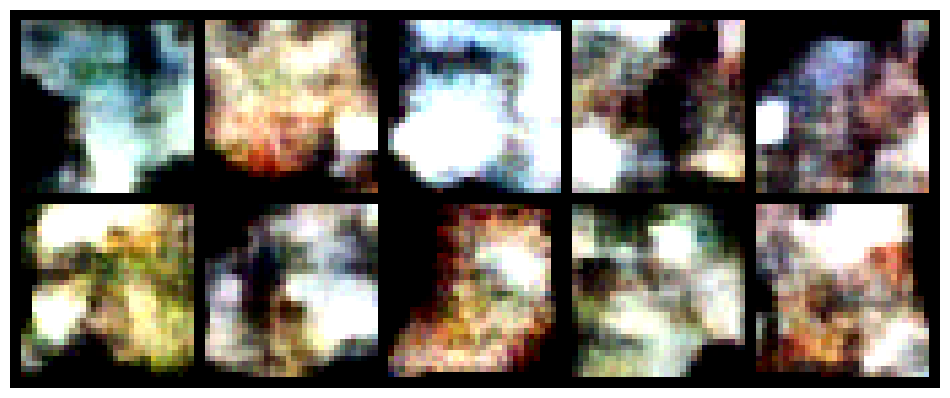

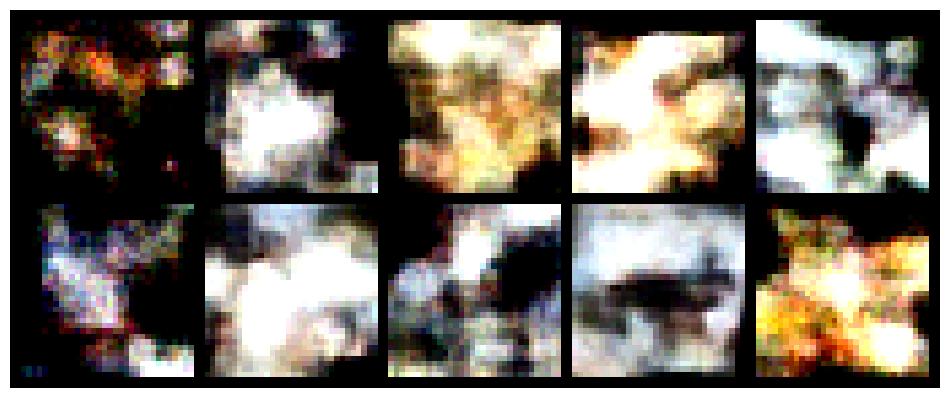

Epoch [3/20] Validation Loss: 0.0996
--------------------------------------------------
Epoch [4/20], Data [10112/50000], Average Loss: 0.0999
Epoch [4/20], Data [20224/50000], Average Loss: 0.0970
Epoch [4/20], Data [30336/50000], Average Loss: 0.0974
Epoch [4/20], Data [40448/50000], Average Loss: 0.0960
Epoch [4/20] completed in 859.50s
Epoch [4/20] Average Training Loss: 0.0970


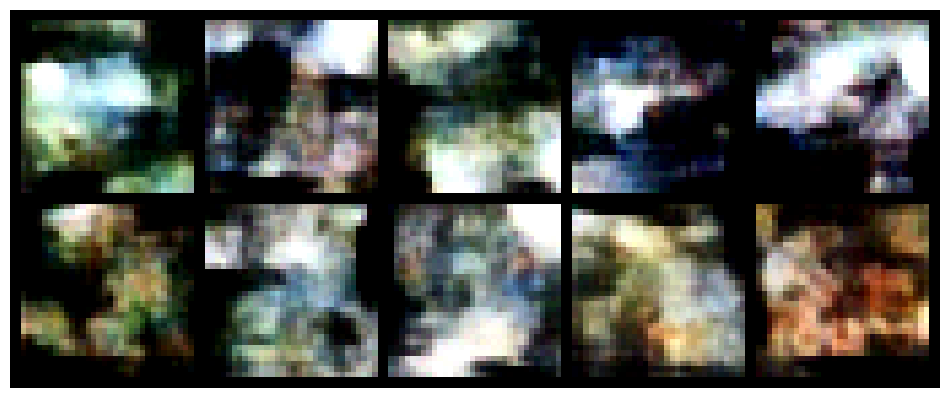

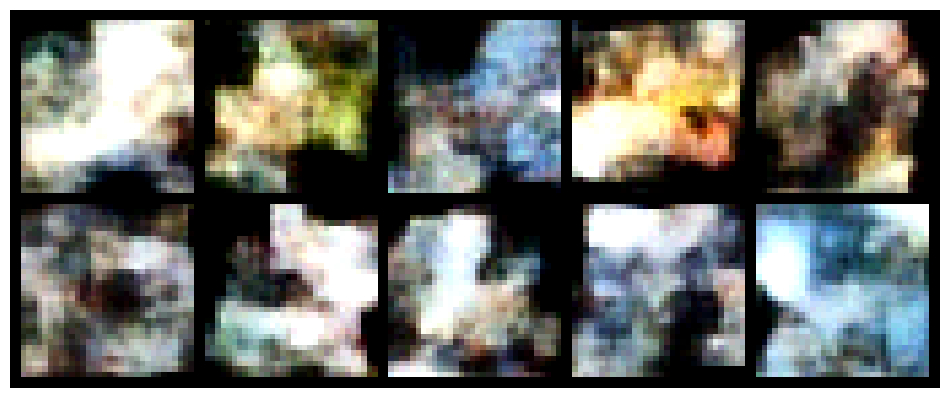

Epoch [4/20] Validation Loss: 0.0938
--------------------------------------------------
Epoch [5/20], Data [10112/50000], Average Loss: 0.0953
Epoch [5/20], Data [20224/50000], Average Loss: 0.0938
Epoch [5/20], Data [30336/50000], Average Loss: 0.0933
Epoch [5/20], Data [40448/50000], Average Loss: 0.0926
Epoch [5/20] completed in 860.27s
Epoch [5/20] Average Training Loss: 0.0935


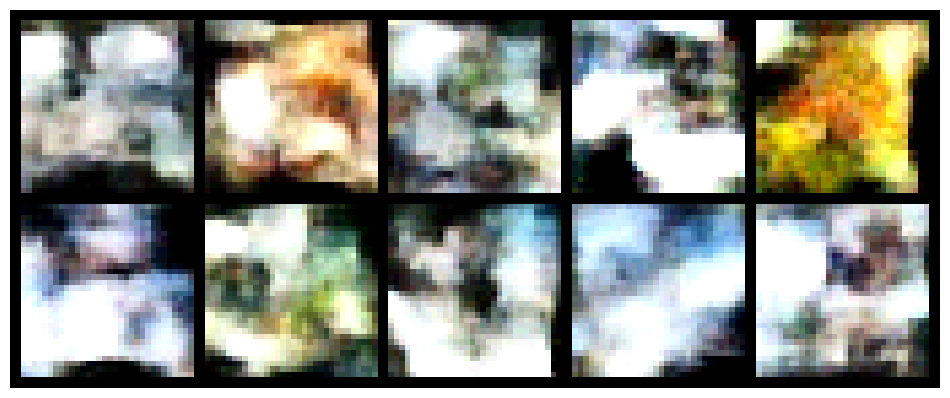

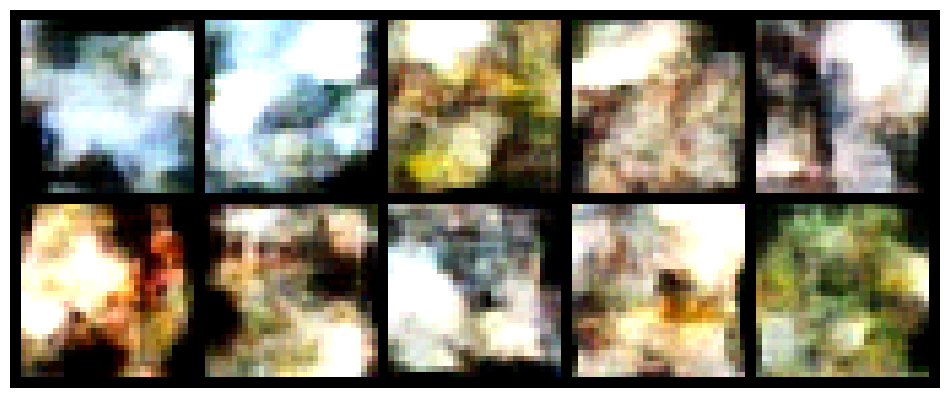

Epoch [5/20] Validation Loss: 0.0906
--------------------------------------------------
Epoch [6/20], Data [10112/50000], Average Loss: 0.0896
Epoch [6/20], Data [20224/50000], Average Loss: 0.0890
Epoch [6/20], Data [30336/50000], Average Loss: 0.0906
Epoch [6/20], Data [40448/50000], Average Loss: 0.0884
Epoch [6/20] completed in 860.91s
Epoch [6/20] Average Training Loss: 0.0896


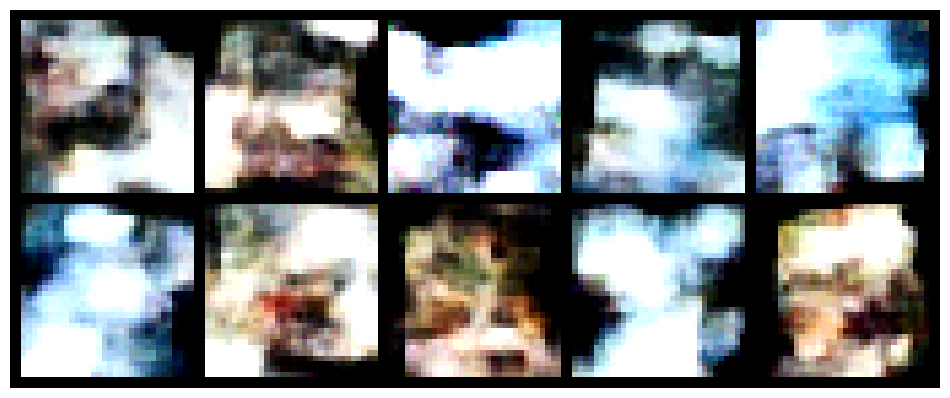

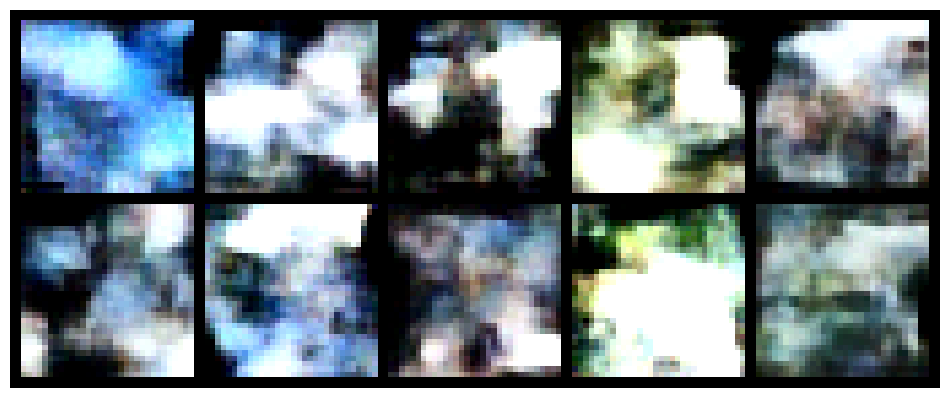

Epoch [6/20] Validation Loss: 0.0919
--------------------------------------------------
Epoch [7/20], Data [10112/50000], Average Loss: 0.0891
Epoch [7/20], Data [20224/50000], Average Loss: 0.0875
Epoch [7/20], Data [30336/50000], Average Loss: 0.0896
Epoch [7/20], Data [40448/50000], Average Loss: 0.0899
Epoch [7/20] completed in 861.38s
Epoch [7/20] Average Training Loss: 0.0891


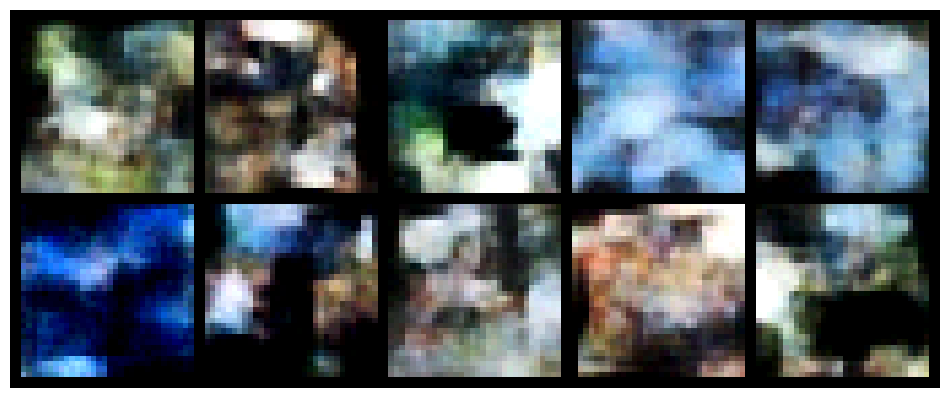

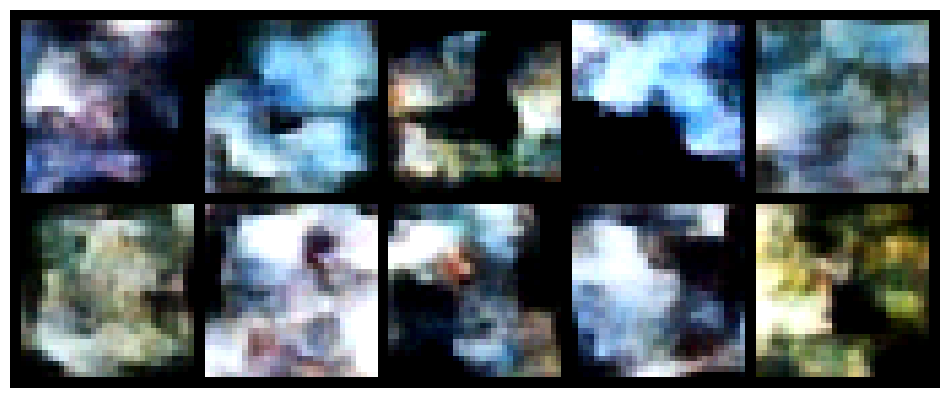

Epoch [7/20] Validation Loss: 0.0883
--------------------------------------------------
Epoch [8/20], Data [10112/50000], Average Loss: 0.0881
Epoch [8/20], Data [20224/50000], Average Loss: 0.0876
Epoch [8/20], Data [30336/50000], Average Loss: 0.0884
Epoch [8/20], Data [40448/50000], Average Loss: 0.0880
Epoch [8/20] completed in 861.40s
Epoch [8/20] Average Training Loss: 0.0876


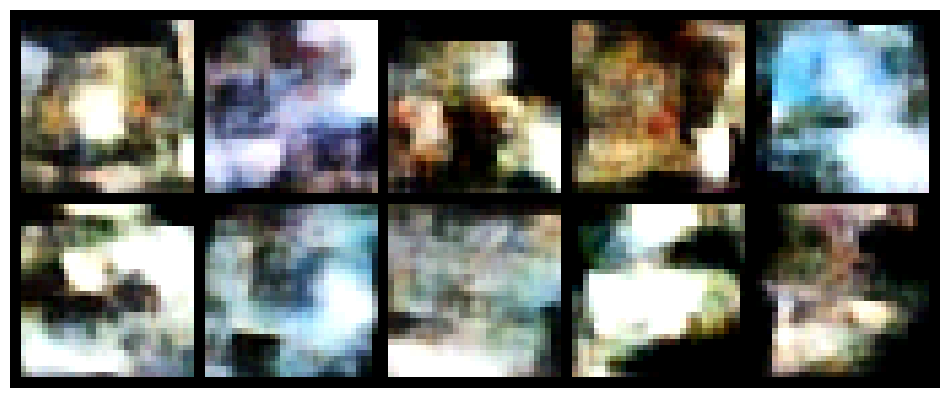

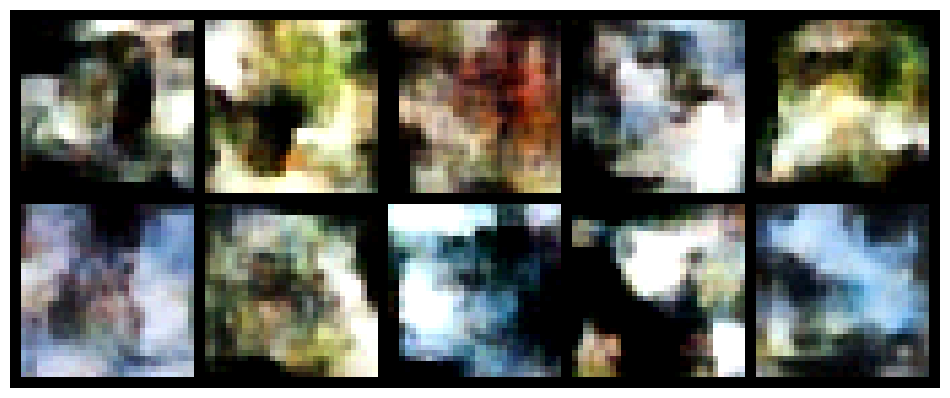

Epoch [8/20] Validation Loss: 0.0869
--------------------------------------------------
Epoch [9/20], Data [10112/50000], Average Loss: 0.0857
Epoch [9/20], Data [20224/50000], Average Loss: 0.0865
Epoch [9/20], Data [30336/50000], Average Loss: 0.0862
Epoch [9/20], Data [40448/50000], Average Loss: 0.0847
Epoch [9/20] completed in 861.05s
Epoch [9/20] Average Training Loss: 0.0857


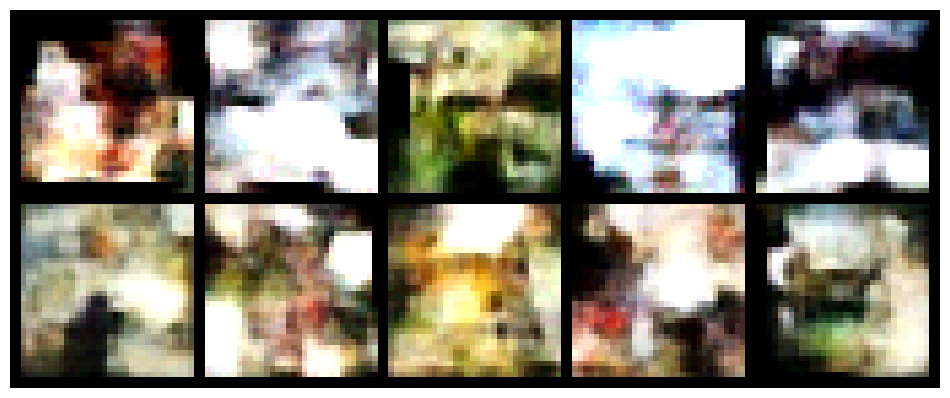

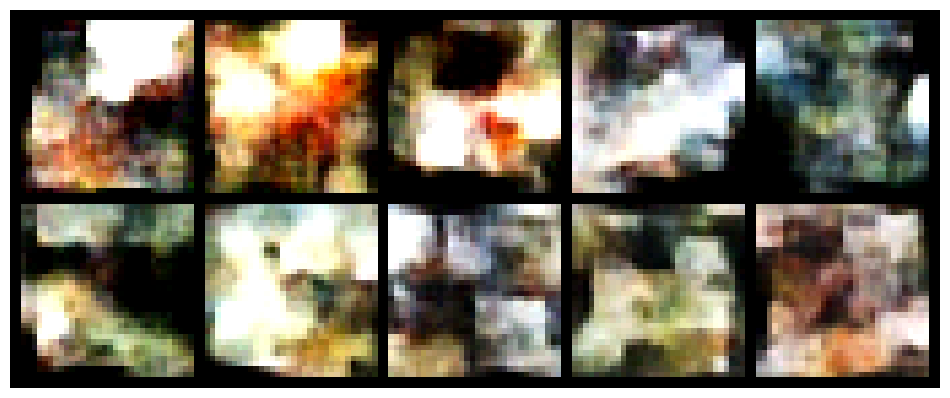

Epoch [9/20] Validation Loss: 0.0869
--------------------------------------------------
Epoch [10/20], Data [10112/50000], Average Loss: 0.0825
Epoch [10/20], Data [20224/50000], Average Loss: 0.0858
Epoch [10/20], Data [30336/50000], Average Loss: 0.0833
Epoch [10/20], Data [40448/50000], Average Loss: 0.0840
Epoch [10/20] completed in 861.23s
Epoch [10/20] Average Training Loss: 0.0840


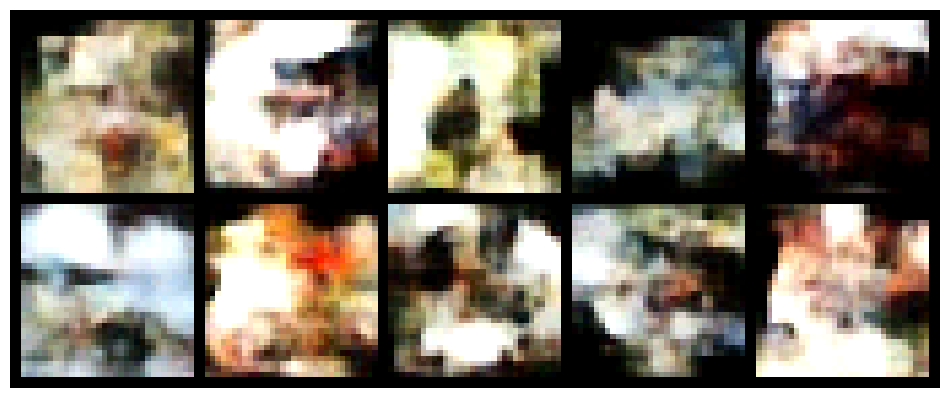

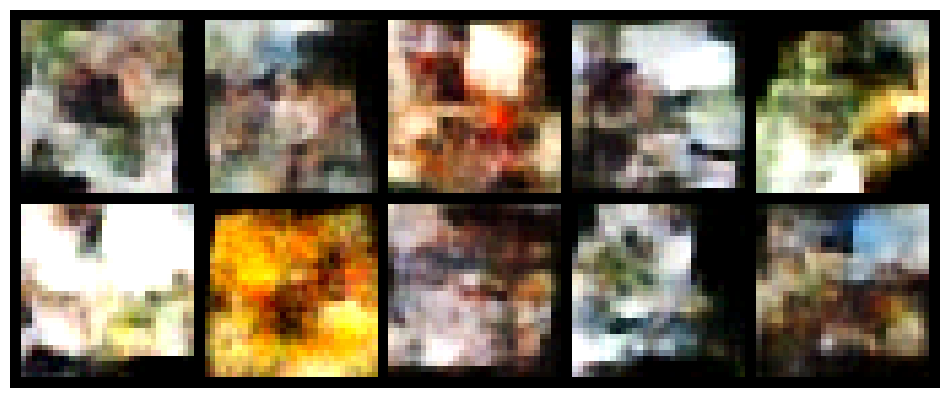

Epoch [10/20] Validation Loss: 0.0862
--------------------------------------------------
Epoch [11/20], Data [10112/50000], Average Loss: 0.0858
Epoch [11/20], Data [20224/50000], Average Loss: 0.0854
Epoch [11/20], Data [30336/50000], Average Loss: 0.0842
Epoch [11/20], Data [40448/50000], Average Loss: 0.0840
Epoch [11/20] completed in 861.80s
Epoch [11/20] Average Training Loss: 0.0848


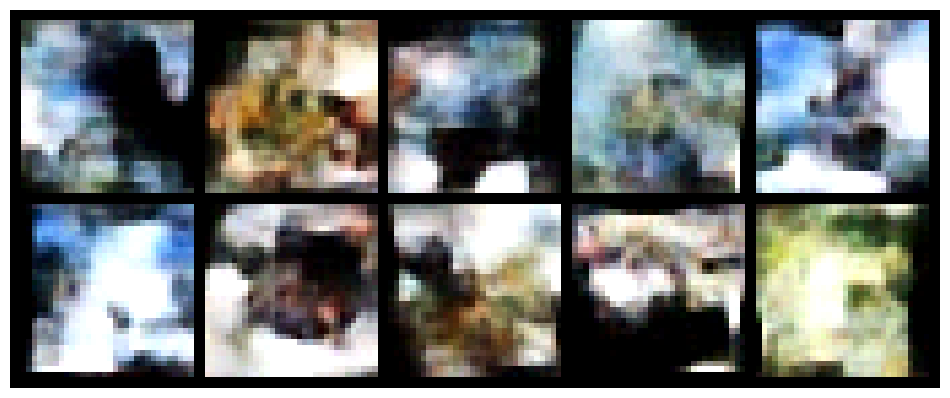

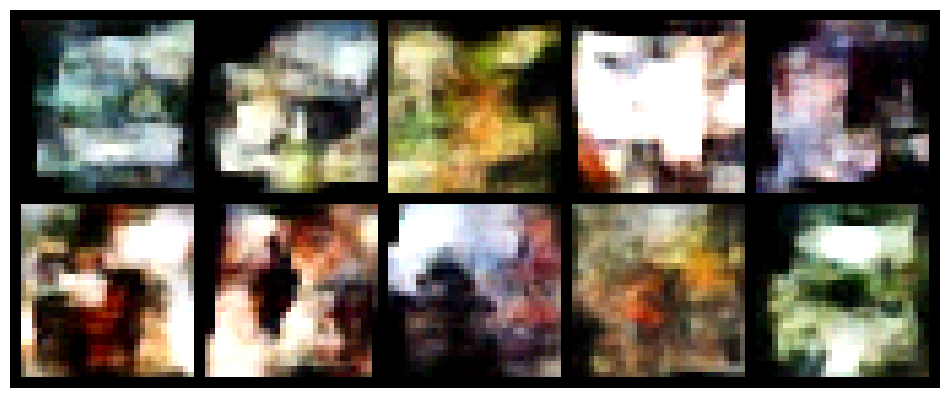

Epoch [11/20] Validation Loss: 0.0852
--------------------------------------------------
Epoch [12/20], Data [10112/50000], Average Loss: 0.0829
Epoch [12/20], Data [20224/50000], Average Loss: 0.0855
Epoch [12/20], Data [30336/50000], Average Loss: 0.0817
Epoch [12/20], Data [40448/50000], Average Loss: 0.0827
Epoch [12/20] completed in 861.54s
Epoch [12/20] Average Training Loss: 0.0830


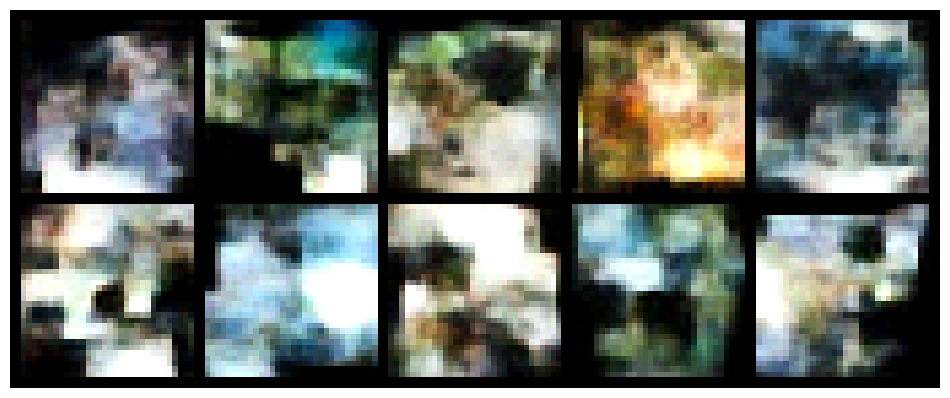

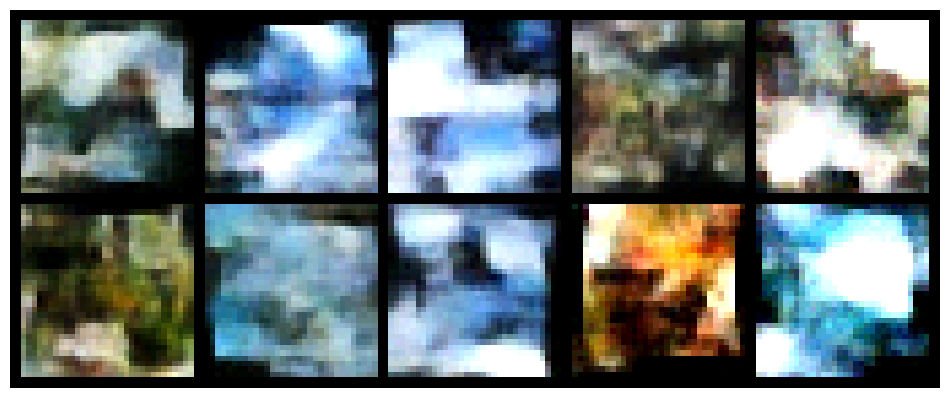

Epoch [12/20] Validation Loss: 0.0844
--------------------------------------------------
Epoch [13/20], Data [10112/50000], Average Loss: 0.0839
Epoch [13/20], Data [20224/50000], Average Loss: 0.0839
Epoch [13/20], Data [30336/50000], Average Loss: 0.0832
Epoch [13/20], Data [40448/50000], Average Loss: 0.0814
Epoch [13/20] completed in 861.65s
Epoch [13/20] Average Training Loss: 0.0832


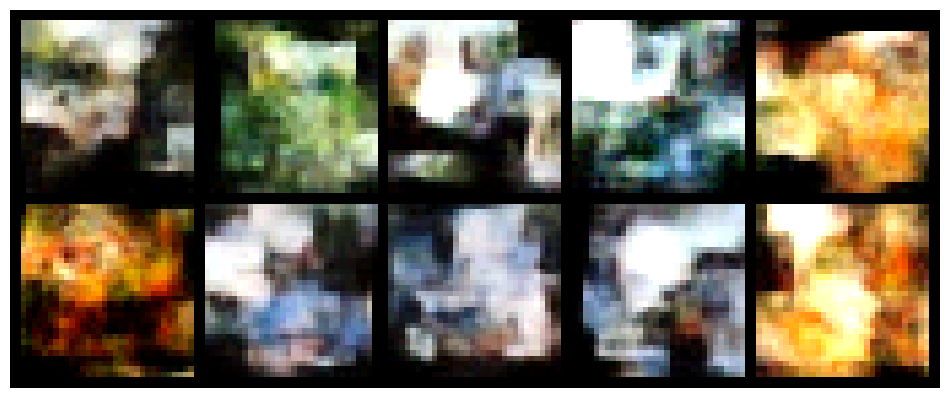

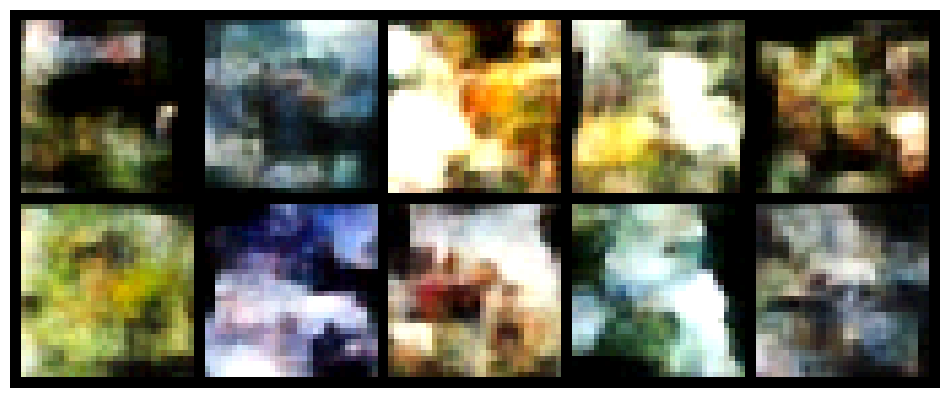

Epoch [13/20] Validation Loss: 0.0837
--------------------------------------------------
Epoch [14/20], Data [10112/50000], Average Loss: 0.0825
Epoch [14/20], Data [20224/50000], Average Loss: 0.0820
Epoch [14/20], Data [30336/50000], Average Loss: 0.0833
Epoch [14/20], Data [40448/50000], Average Loss: 0.0819
Epoch [14/20] completed in 861.96s
Epoch [14/20] Average Training Loss: 0.0823


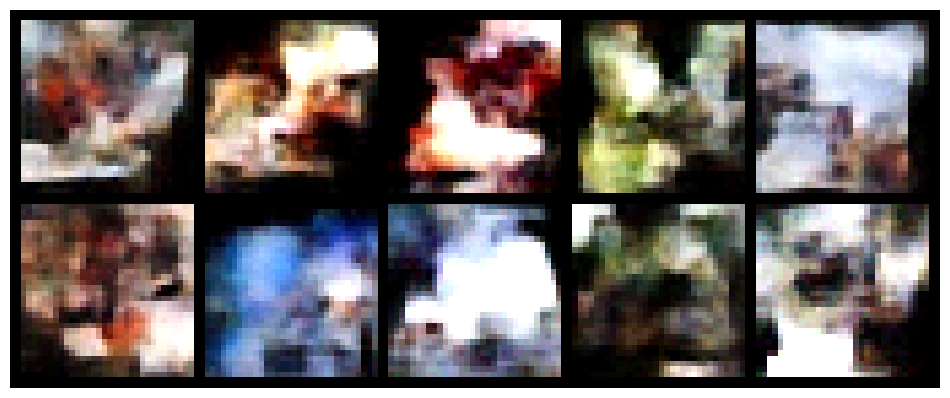

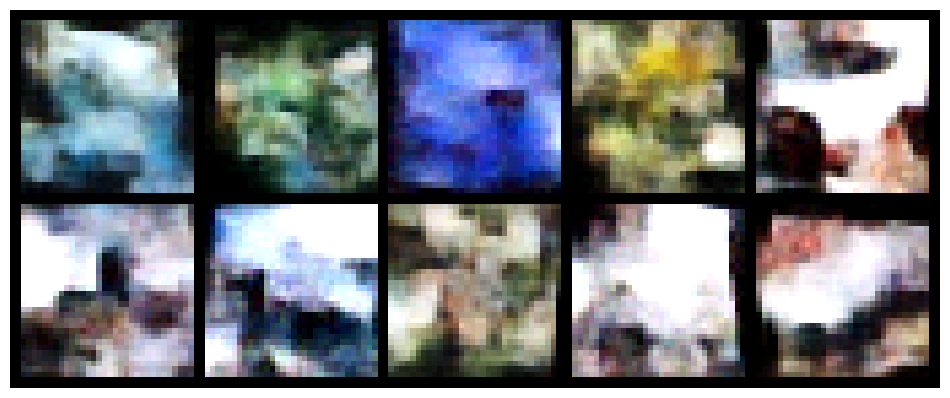

Epoch [14/20] Validation Loss: 0.0835
--------------------------------------------------
Epoch [15/20], Data [10112/50000], Average Loss: 0.0808
Epoch [15/20], Data [20224/50000], Average Loss: 0.0834
Epoch [15/20], Data [30336/50000], Average Loss: 0.0824
Epoch [15/20], Data [40448/50000], Average Loss: 0.0829
Epoch [15/20] completed in 861.55s
Epoch [15/20] Average Training Loss: 0.0823


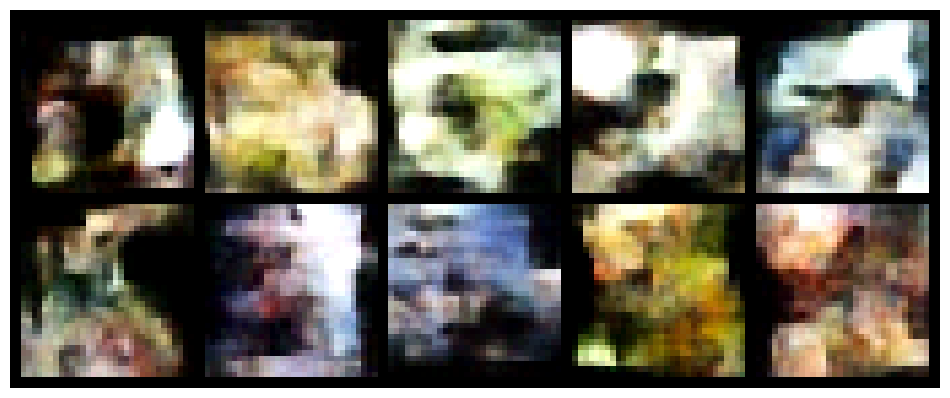

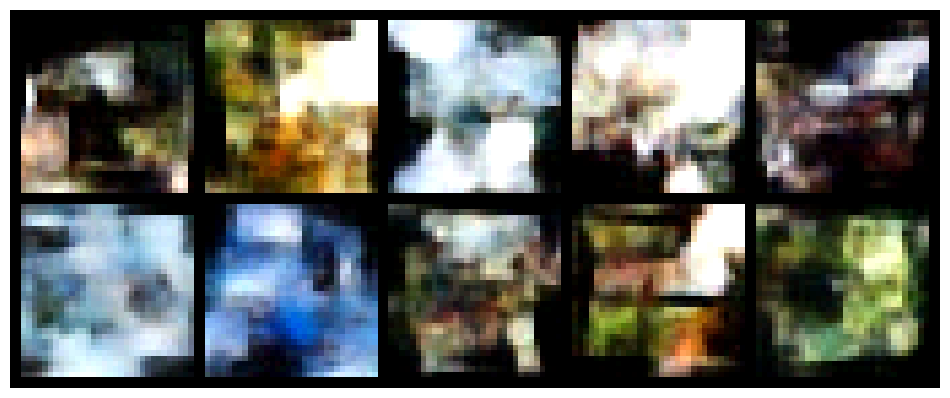

Epoch [15/20] Validation Loss: 0.0838
--------------------------------------------------
Epoch [16/20], Data [10112/50000], Average Loss: 0.0815
Epoch [16/20], Data [20224/50000], Average Loss: 0.0823
Epoch [16/20], Data [30336/50000], Average Loss: 0.0801
Epoch [16/20], Data [40448/50000], Average Loss: 0.0802
Epoch [16/20] completed in 862.67s
Epoch [16/20] Average Training Loss: 0.0811


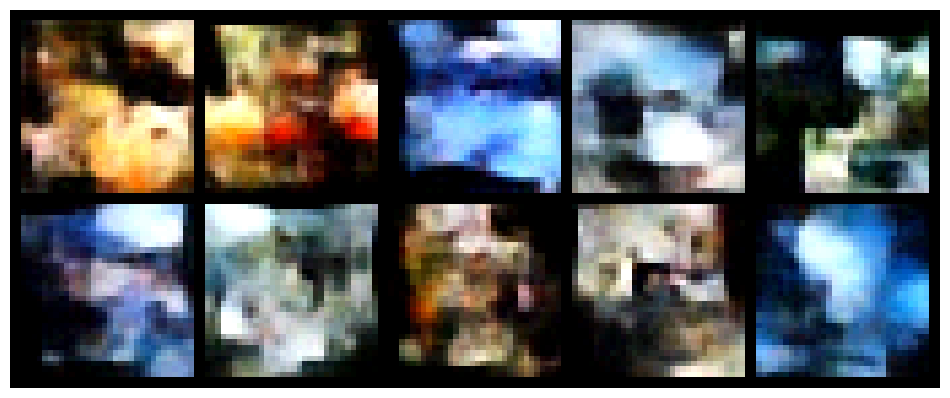

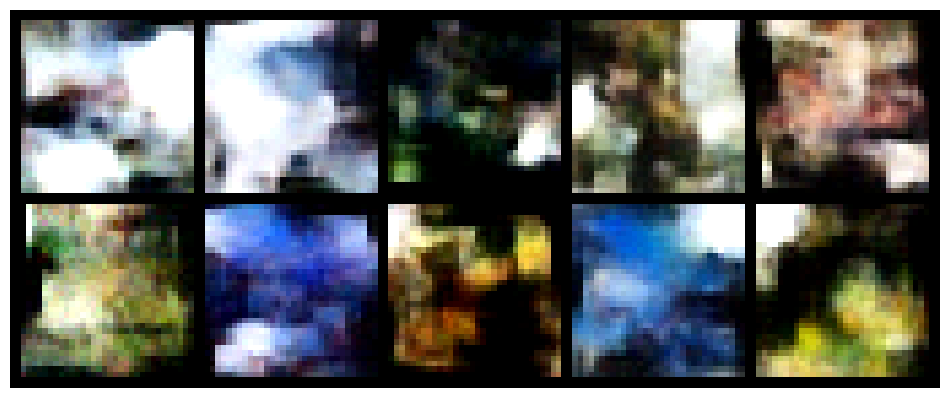

Epoch [16/20] Validation Loss: 0.0838
--------------------------------------------------
Epoch [17/20], Data [10112/50000], Average Loss: 0.0817
Epoch [17/20], Data [20224/50000], Average Loss: 0.0815
Epoch [17/20], Data [30336/50000], Average Loss: 0.0809
Epoch [17/20], Data [40448/50000], Average Loss: 0.0804
Epoch [17/20] completed in 863.15s
Epoch [17/20] Average Training Loss: 0.0811


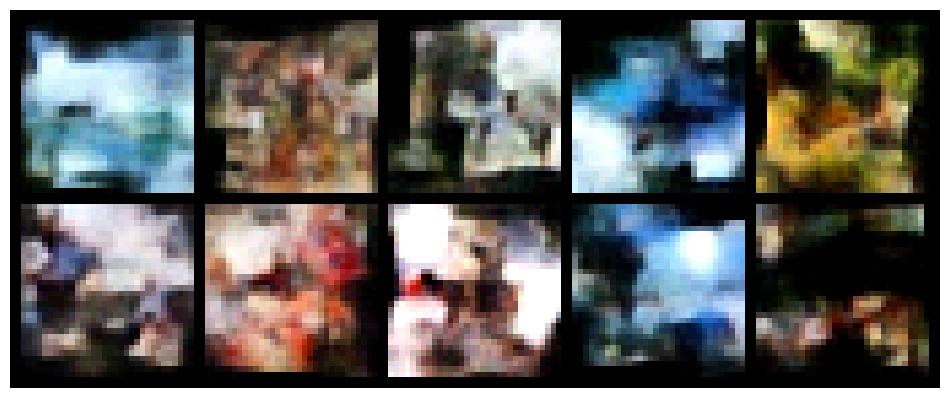

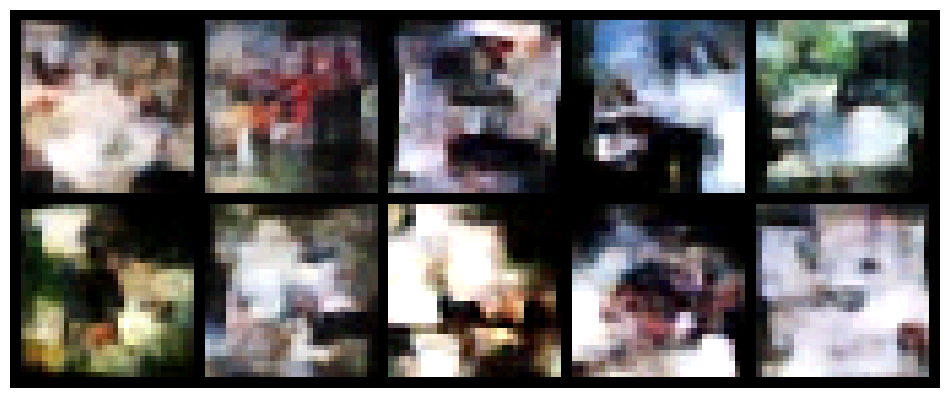

Epoch [17/20] Validation Loss: 0.0815
--------------------------------------------------
Epoch [18/20], Data [10112/50000], Average Loss: 0.0790
Epoch [18/20], Data [20224/50000], Average Loss: 0.0808
Epoch [18/20], Data [30336/50000], Average Loss: 0.0804
Epoch [18/20], Data [40448/50000], Average Loss: 0.0802
Epoch [18/20] completed in 862.88s
Epoch [18/20] Average Training Loss: 0.0804


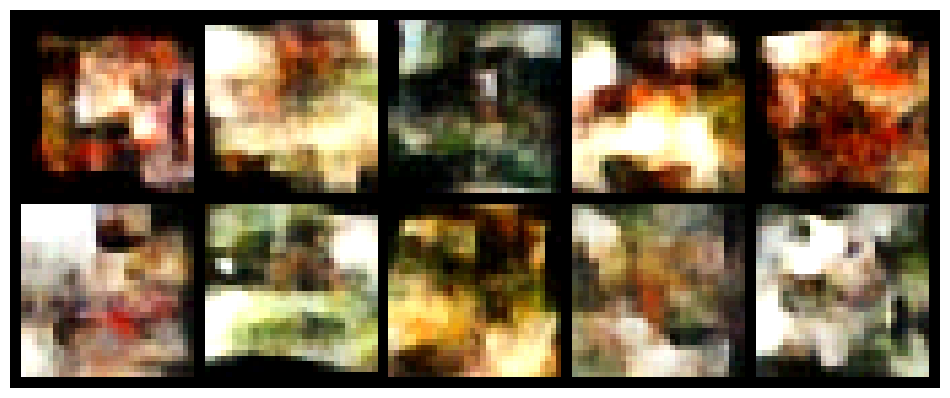

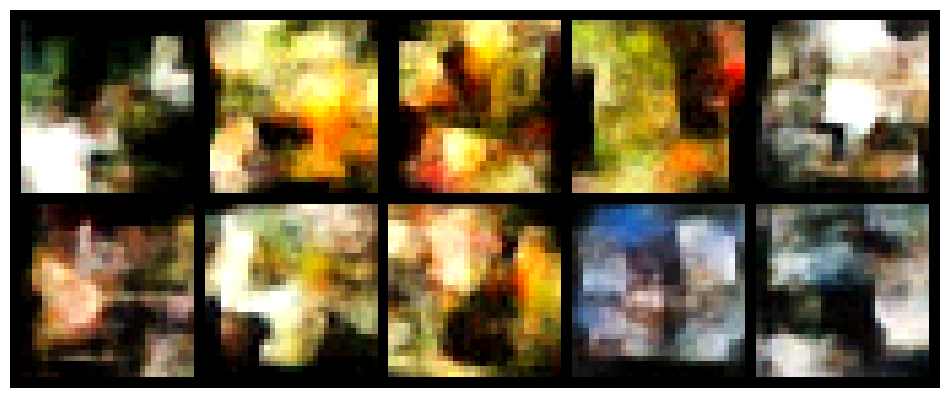

Epoch [18/20] Validation Loss: 0.0834
--------------------------------------------------
Epoch [19/20], Data [10112/50000], Average Loss: 0.0797
Epoch [19/20], Data [20224/50000], Average Loss: 0.0828
Epoch [19/20], Data [30336/50000], Average Loss: 0.0801
Epoch [19/20], Data [40448/50000], Average Loss: 0.0800
Epoch [19/20] completed in 863.10s
Epoch [19/20] Average Training Loss: 0.0812


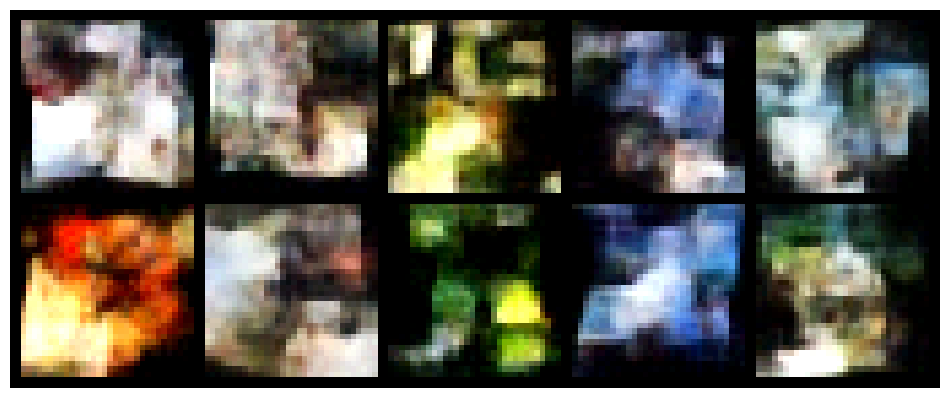

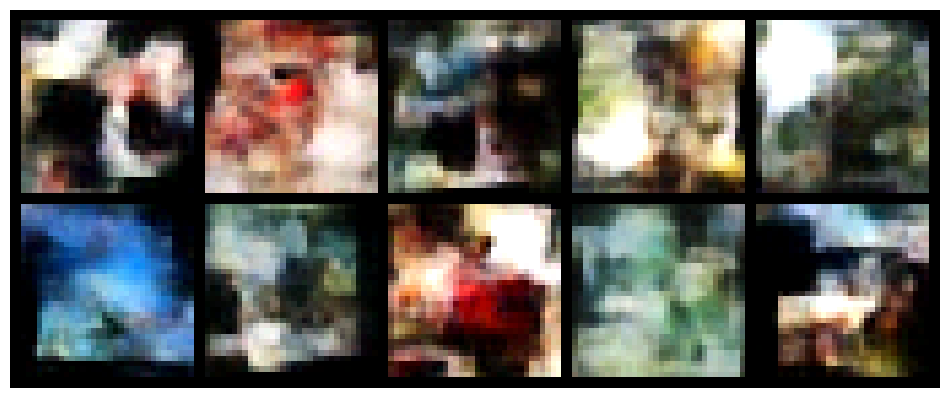

Epoch [19/20] Validation Loss: 0.0829
--------------------------------------------------
Epoch [20/20], Data [10112/50000], Average Loss: 0.0799
Epoch [20/20], Data [20224/50000], Average Loss: 0.0803
Epoch [20/20], Data [30336/50000], Average Loss: 0.0797
Epoch [20/20], Data [40448/50000], Average Loss: 0.0816
Epoch [20/20] completed in 862.91s
Epoch [20/20] Average Training Loss: 0.0804


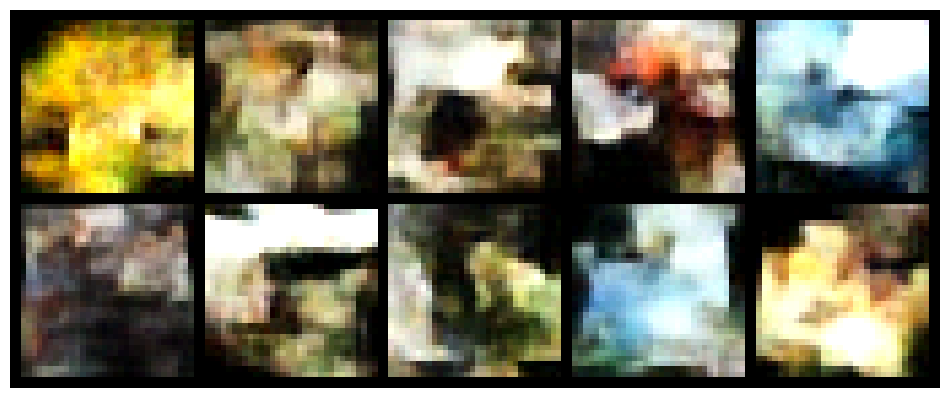

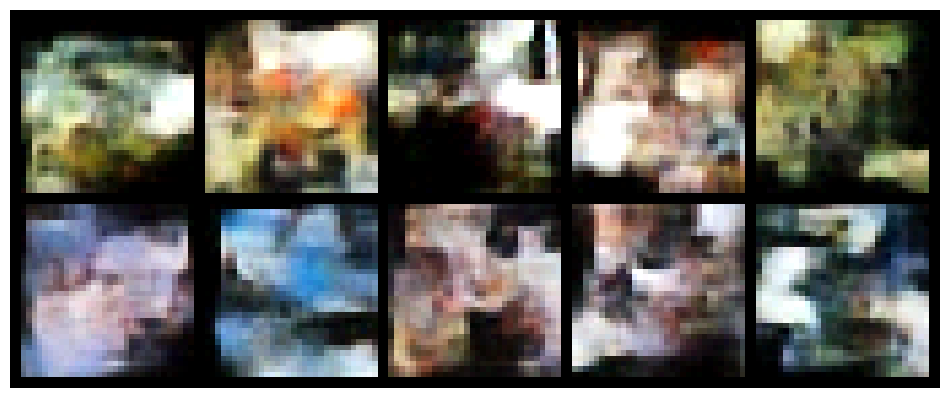

Epoch [20/20] Validation Loss: 0.0840
--------------------------------------------------
Training finished.


In [ ]:
train(model, trainloader, testloader)

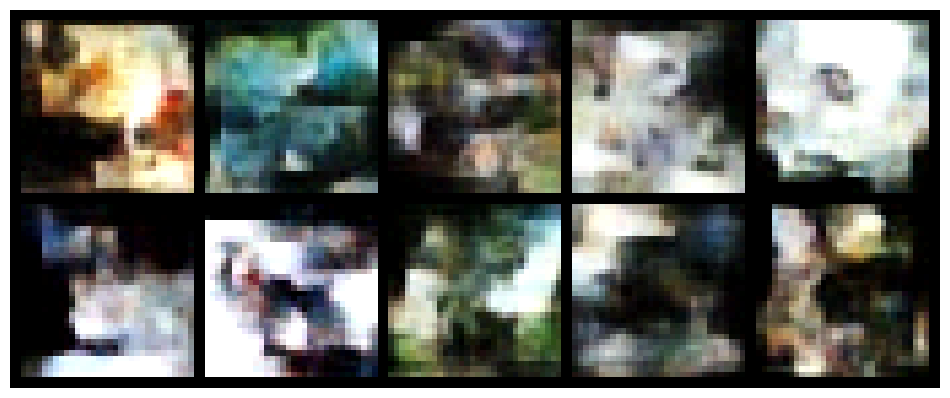

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

def sample_images(model, noise_schedule, num_samples=10, device='cuda'):
    model.eval()
    model.to(device)

    # Precompute constants
    betas = noise_schedule.to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)
    timesteps = noise_schedule.shape[0]

    # Start from random noise
    x_t = torch.randn(num_samples, 3, 32, 32).to(device)

    for t in reversed(range(0, timesteps)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.float32)

        # Predict noise using the model
        with torch.no_grad():
            noise_pred = model(x_t, t_tensor.view(-1, 1, 1, 1))

        beta_t = betas[t]
        sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t]
        sqrt_recip_alpha_t = 1 / torch.sqrt(1 - beta_t)

        if t > 0:
            noise = torch.randn_like(x_t)
        else:
            noise = torch.zeros_like(x_t)

        # Update x_t to x_{t-1} using the reverse diffusion equation
        x_t = (1 / torch.sqrt(1 - beta_t)) * (x_t - (beta_t / sqrt_one_minus_alpha_cumprod_t) * noise_pred) + torch.sqrt(beta_t) * noise

    # x_t now contains the generated images x_0
    x_0 = x_t
    x_0 = x_0.detach().cpu()

    # Unnormalize the images (assuming normalization was with mean=0.5, std=0.5)
    x_0 = x_0 * 0.5 + 0.5
    x_0 = torch.clamp(x_0, 0.0, 1.0)

    # Create a grid of images and display them
    grid = torchvision.utils.make_grid(x_0, nrow=5)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Now call the function to sample and display images
sample_images(model, noise_schedule, num_samples=10, device='cuda')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

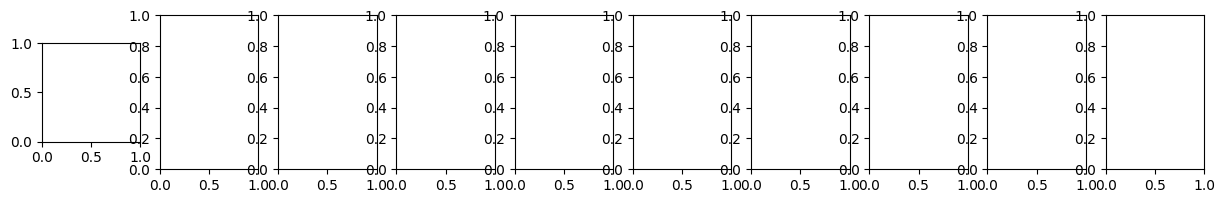

In [ ]:
def sample_images(model, noise_schedule, img_size=32, channels=3, num_samples=10, timesteps=1000, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Initialize random noise
        x_t = torch.randn((num_samples, channels, img_size, img_size), device=device)

        # Precompute values based on noise_schedule
        alphas = 1 - noise_schedule
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_recip_alphas_cumprod = torch.sqrt(1 / alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

        # Iterate through timesteps in reverse
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)

            # Predict noise
            predicted_noise = model(x_t, t_tensor.float().unsqueeze(1).unsqueeze(1).unsqueeze(1))

            # Compute the denoised image at time step t - 1
            if t > 0:
                noise = torch.randn_like(x_t)
                x_t = sqrt_recip_alphas_cumprod[t] * (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) + torch.sqrt(noise_schedule[t]) * noise
            else:
                x_t = sqrt_recip_alphas_cumprod[t] * (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise)

        # Denormalize for visualization
        x_t = (x_t + 1) * 0.5
        return x_t
# Assuming you have the 'noise_schedule' and 'model' already defined
generated_images = sample_images(model, noise_schedule, num_samples=10, device='cuda')

# Visualize the generated images using matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for img, ax in zip(generated_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def sample_images(model, noise_schedule, img_size=32, channels=3, num_samples=10, timesteps=1000, device='cuda'):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Step 1: Initialize random noise
        x_t = torch.randn((num_samples, channels, img_size, img_size), device=device)  # Random noise (shape: num_samples x channels x img_size x img_size)

        # Step 2: Precompute alphas and betas from the noise schedule
        alphas = 1 - noise_schedule
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_recip_alphas_cumprod = torch.sqrt(1 / alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

        # Step 3: Iterate through timesteps in reverse to gradually denoise
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)

            # Step 4: Predict the noise to be removed
            predicted_noise = model(x_t, t_tensor.float().unsqueeze(1).unsqueeze(1).unsqueeze(1))

            # Step 5: Compute the denoised image at time step t - 1
            if t > 0:
                noise = torch.randn_like(x_t)  # Sample noise to add to the image
                x_t = (sqrt_recip_alphas_cumprod[t] * (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) +
                       torch.sqrt(noise_schedule[t]) * noise)
            else:
                # For the last step, return the final denoised image without adding noise
                x_t = sqrt_recip_alphas_cumprod[t] * (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise)

        # Step 6: Denormalize the output image for visualization (from [-1, 1] to [0, 1])
        x_t = (x_t + 1) * 0.5  # Scale to [0, 1]

        # Step 7: Plot and display the generated samples
        grid_size = int(num_samples ** 0.5)
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        for i, ax in enumerate(axes.flat):
            img = x_t[i].permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for display
            ax.imshow(img.clip(0, 1))  # Clip values to ensure they're in the [0, 1] range
            ax.axis('off')

        plt.show()

# Example usage
# Make sure that noise_schedule, model, and device are defined as per your setup.
sample_images(model, noise_schedule, num_samples=10, device='cuda')


In [ ]:
import torch

def sample_images(model, noise_schedule, num_samples=10, device='cuda'):
    model.eval()  # Set the model to evaluation mode

    # Precompute constants
    betas = noise_schedule.to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])

    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_recipm1_alphas = torch.sqrt(1.0 / alphas - 1)

    timesteps = noise_schedule.shape[0]

    # Start from pure noise (for each sample in the batch)
    x_t = torch.randn(num_samples, 3, 32, 32, device=device)

    with torch.no_grad():
        for t in reversed(range(timesteps)):
            t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

            # Model prediction
            t_emb = t_batch.float().unsqueeze(1)
            epsilon_theta = model(x_t, t_emb)

            # Compute coefficients
            alpha_t = alphas[t]
            beta_t = betas[t]
            sqrt_recip_alpha_t = sqrt_recip_alphas[t]
            sqrt_one_minus_alpha_cumprod_t = sqrt_one_minus_alphas_cumprod[t]

            # Compute x_{t-1} using the reverse process formula
            x_t_minus1 = sqrt_recip_alpha_t * (x_t - (beta_t / sqrt_one_minus_alpha_cumprod_t) * epsilon_theta)

            if t > 0:
                noise = torch.randn_like(x_t)
                sigma_t = torch.sqrt(beta_t)
                x_t = x_t_minus1 + sigma_t * noise
            else:
                x_t = x_t_minus1

    x_0 = x_t

    # Denormalize the images (assuming normalization was with mean=0.5 and std=0.5)
    x_0 = (x_0 * 0.5) + 0.5
    x_0 = torch.clamp(x_0, 0.0, 1.0)  # Ensure pixel values are in [0, 1]

    # Optionally, convert to CPU and NumPy for visualization
    x_0 = x_0.cpu().permute(0, 2, 3, 1).numpy()

    # Return the generated images
    return x_0

# Assuming you have the 'noise_schedule' and 'model' already defined
generated_images = sample_images(model, noise_schedule, num_samples=10, device='cuda')

# Visualize the generated images using matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for img, ax in zip(generated_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def sample_images_with_intermediate_steps(model, noise_schedule, img_size=32, channels=3, num_samples=10, timesteps=1000, device='cuda'):
    model.eval()  # Set the model to evaluation mode

    # We'll store images at 10 equally spaced timesteps
    intermediate_steps = 10
    step_interval = timesteps // intermediate_steps

    # Initialize random noise
    x_t = torch.randn((num_samples, channels, img_size, img_size), device=device)

    # Precompute values based on the noise schedule
    alphas = 1 - noise_schedule
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    sqrt_recip_alphas_cumprod = torch.sqrt(1 / alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

    # Create a list to store images at each intermediate step
    images_at_steps = []

    with torch.no_grad():
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)

            # Predict noise at this timestep
            predicted_noise = model(x_t, t_tensor.float().unsqueeze(1).unsqueeze(1).unsqueeze(1))

            # Compute the denoised image for time step t-1
            if t > 0:
                noise = torch.randn_like(x_t)
                x_t = sqrt_recip_alphas_cumprod[t] * (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) + torch.sqrt(noise_schedule[t]) * noise
            else:
                x_t = sqrt_recip_alphas_cumprod[t] * (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise)

            # Store intermediate images at evenly spaced timesteps
            if t % step_interval == 0:
                denormalized_x_t = (x_t + 1) * 0.5  # Rescale to [0, 1] for visualization
                images_at_steps.append(denormalized_x_t.cpu())  # Move to CPU for later visualization

    # Plot and display the intermediate samples
    fig, axes = plt.subplots(intermediate_steps, num_samples, figsize=(num_samples * 2, intermediate_steps * 2))
    for step_idx, step_images in enumerate(images_at_steps):
        for img_idx in range(num_samples):
            img = step_images[img_idx].permute(1, 2, 0).numpy()  # Convert to HWC format for display
            axes[step_idx, img_idx].imshow(img.clip(0, 1))  # Clip values to [0, 1] range
            axes[step_idx, img_idx].axis('off')

    plt.show()

# Example usage
# Make sure that `noise_schedule`, `model`, and `device` are defined as per your setup.
sample_images_with_intermediate_steps(model, noise_schedule, num_samples=10, device='cuda')


In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()